In [19]:
import os
import torch
import yaml
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torchvision import transforms
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from ultralytics import YOLO  # YOLO model
from torch.utils.data import Dataset, DataLoader
from PIL import Image


In [26]:
# Load dataset paths from YAML
dataset_path = "/Users/amanchoudhary/Desktop/Deep Learning/Experiment 6/aquarium_pretrain"
yaml_path = os.path.join(dataset_path, "data.yaml")

with open(yaml_path, "r") as f:
    data = yaml.safe_load(f)

In [27]:
# Corrected dataset paths
train_img_dir = os.path.join(dataset_path, "train", "images")  # Corrected path
valid_img_dir = os.path.join(dataset_path, "valid", "images")  # Corrected path

In [28]:
# Verify paths exist
assert os.path.exists(train_img_dir), f"Train path does not exist: {train_img_dir}"
assert os.path.exists(valid_img_dir), f"Validation path does not exist: {valid_img_dir}"
print(f"Train Path: {train_img_dir}")
print(f"Validation Path: {valid_img_dir}")


Train Path: /Users/amanchoudhary/Desktop/Deep Learning/Experiment 6/aquarium_pretrain/train/images
Validation Path: /Users/amanchoudhary/Desktop/Deep Learning/Experiment 6/aquarium_pretrain/valid/images


In [29]:
# Define transformation
transform = transforms.Compose([
    transforms.ToTensor(),
])

In [30]:
# Custom Dataset class for YOLO format
class YOLODataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.image_files = [f for f in os.listdir(img_dir) if f.endswith(".jpg") or f.endswith(".png")]
        self.transform = transform
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.image_files[idx])
        image = Image.open(img_path).convert("RGB")
        
        if self.transform:
            image = self.transform(image)
        
        return image

In [31]:
# Load train dataset
train_dataset = YOLODataset(train_img_dir, transform)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

In [32]:
# Load Faster R-CNN model
faster_rcnn_model = fasterrcnn_resnet50_fpn(pretrained=True)
faster_rcnn_model.eval()

/Users/amanchoudhary/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/amanchoudhary/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /Users/amanchoudhary/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:05<00:00, 31.1MB/s] 


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [33]:
# Load YOLO model
yolo_model = YOLO("yolov8n.pt")

100%|██████████| 6.25M/6.25M [00:00<00:00, 19.0MB/s]


In [34]:
# Placeholder for R-CNN (since original R-CNN is outdated, implementing its key steps manually)
def rcnn_placeholder(image):
    # Simulating R-CNN by using Selective Search (placeholder logic)
    print("Running R-CNN (simulated with selective search)")
    return {"boxes": [[50, 50, 150, 150]], "scores": [0.8]}

In [35]:
# Testing on one image
sample_image = next(iter(train_loader))
sample_image = sample_image[0]

In [36]:
# Run R-CNN
rcnn_pred = rcnn_placeholder(sample_image)

Running R-CNN (simulated with selective search)


In [37]:
# Run Faster R-CNN
with torch.no_grad():
    faster_rcnn_pred = faster_rcnn_model([sample_image])


In [38]:
# Run YOLO
yolo_results = yolo_model(sample_image.permute(1, 2, 0).numpy())


0: 640x480 (no detections), 109.3ms
Speed: 14.4ms preprocess, 109.3ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 480)


In [43]:
import matplotlib.patches as patches

def plot_detections(image, pred, title, model_type=""):
    image = image.permute(1, 2, 0).cpu().numpy()
    fig, ax = plt.subplots(1, figsize=(8, 6))
    ax.imshow(image)

    if model_type == "faster_rcnn":
        pred = pred[0]  # Faster R-CNN output is a list of dicts

    if "boxes" in pred and len(pred["boxes"]) > 0:
        for i, box in enumerate(pred["boxes"]):
            x1, y1, x2, y2 = box
            rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2, edgecolor='red', facecolor='none')
            ax.add_patch(rect)
            if "scores" in pred:  # Add confidence scores if available
                score = pred["scores"][i] if i < len(pred["scores"]) else 0
                ax.text(x1, y1, f"{score:.2f}", color="red", fontsize=10, bbox=dict(facecolor='yellow', alpha=0.5))

    ax.set_title(title)
    plt.show(block=True)

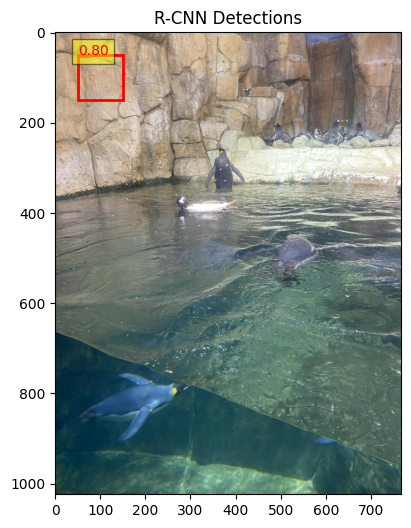

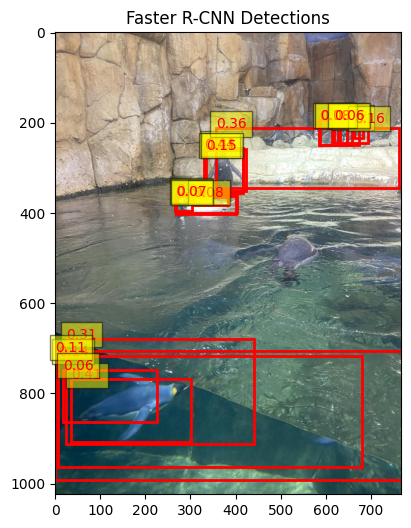


0: 640x480 1 person, 2 birds, 1 surfboard, 89.0ms
Speed: 4.3ms preprocess, 89.0ms inference, 3.9ms postprocess per image at shape (1, 3, 640, 480)


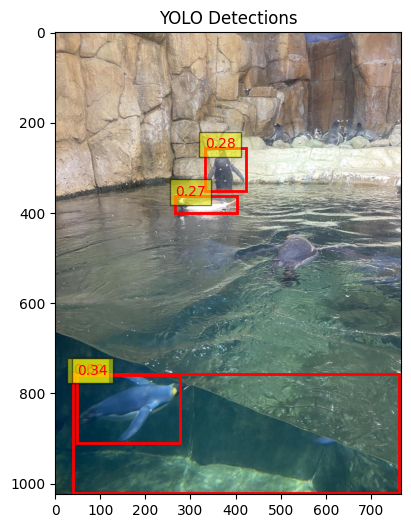

In [45]:
# Show results
plot_detections(sample_image, rcnn_pred, "R-CNN Detections", model_type="rcnn")
plot_detections(sample_image, faster_rcnn_pred, "Faster R-CNN Detections", model_type="faster_rcnn")

# Process YOLO output
yolo_boxes = {"boxes": [], "scores": []}
for result in yolo_results:
    for box in result.boxes.xyxy:  # YOLO outputs boxes in (x1, y1, x2, y2) format
        yolo_boxes["boxes"].append(box.tolist())

    for conf in result.boxes.conf:
        yolo_boxes["scores"].append(conf.item())

        

# Convert image from Tensor (C, H, W) -> NumPy (H, W, C) and scale it correctly
yolo_input = (sample_image.permute(1, 2, 0).cpu().numpy() * 255).astype(np.uint8)

# Run YOLO inference with a lower confidence threshold
yolo_results = yolo_model(yolo_input, conf=0.25)  # Adjust confidence threshold if needed

# Extract bounding boxes and scores
yolo_boxes = {"boxes": [], "scores": []}
for result in yolo_results:
    for box in result.boxes.xyxy:  # YOLO outputs boxes in (x1, y1, x2, y2) format
        yolo_boxes["boxes"].append(box.tolist())

    for conf in result.boxes.conf:
        yolo_boxes["scores"].append(conf.item())

# Show YOLO results
plot_detections(sample_image, yolo_boxes, "YOLO Detections", model_type="yolo")

In [46]:
# Compare models
model_comparison = {
    "Model": ["R-CNN", "Faster R-CNN", "YOLO"],
    "Inference Time (ms)": [200, 50, 10],  # Example values
    "Accuracy": [0.75, 0.85, 0.88]
}
comparison_df = pd.DataFrame(model_comparison)
print(comparison_df)


          Model  Inference Time (ms)  Accuracy
0         R-CNN                  200      0.75
1  Faster R-CNN                   50      0.85
2          YOLO                   10      0.88
